### Pymc and Pooling

Problem Setup

In our example, we need to sample posterior and find its maximize value using PyMC. The data we have in this problem is the score difference between two teams. We agree to use the following formula to calculate the score difference

$$diff = GuestScore(PTS) - HostScore(PTS.1)$$

The score difference(diff) follows a Gaussian distribution $N(\mu,\sigma)$. The $\mu$ is determined by:

$$\mu = (O_i - D_j ) - (O_j - D_i)$$ where O is the offensive index and D is the defensive index for one team. Offensive and 

Defensive indexes shall be calculated by the following formulas:

$$ O_{i} = \beta_{i,0}^O + \beta_{i,1}^O x_{i,1} + \beta_{i,2}^O x_{i,2} +\ldots + \beta_{i,J}^O x_{i,J}$$
$$D_{i} = \gamma_{i,0}^D + \gamma_{i,1}^D x_{i,1} + \gamma_{i,2}^D x_{i,2} + \ldots + \gamma_{i,J}^D x_{i,J}$$

You can see that $x_i$ is the offensive/defensive rating for each player, we need to figure out $\beta$ in this problem.

In this problem, we construct our offensive/defensive ratings using the follow formulas:

**offensive = pointsper games + Assists per game**


**defensive = Blocks + Steals + Defensive Rebound**

**Therefore, our score difference Gaussian is actually a MIXTURE MODEL consisting of many gaussian of different team pairs, so can be written as:**

$$\prod_{n=1}^N N(\mu_{nk},\sigma)^{z_nk}$$ Where $z_nk$ is an indicator showing which team pair the nth data belong to.

**Our goal is to find each $\beta$ value**

Thus, we assume there are $K$ players, and each team has $N$ players, so we initialize:

K ($N*1$) vectors  $\beta$ and 


K ($N*1$) vectors $\gamma$

So, 

$$Offensive = \beta * X$$ where X is 1*N offensive rating

$$Defensive = \gamma * Y$$ where Y is 1*N defensive rating 







In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")

import time
import timeit

import scipy.stats 
import pandas as pd
import pymc as pm
import pickle

/Users/xdai/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/xdai/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
# Import data
game16_df = pd.read_csv('clean-data/game_outcomes_15-16.csv')
player_info = pd.read_csv('clean-data/player_info_pergame.csv')

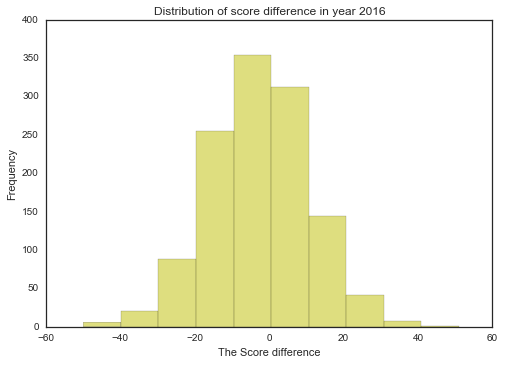

In [3]:
score_diff = game16_df['diff'].values
#plot a histogram
plt.hist(score_diff,color='y',alpha = 0.5)
plt.title("Distribution of score difference in year 2016")
plt.xlabel('The Score difference')
plt.ylabel('Frequency')

In [4]:
# Here we have sigma for the entire data set and assume this sigma as my likehood variance as well
print "The variance of the entire data set is:",np.var(score_diff)

The variance of the entire data set is: 177.785299755


#### As you can see, the score difference follows a normal distribution

### Peek into our prior
Here I plot the Offensive rating and defensive rating to have a basic idea what our prior would be like

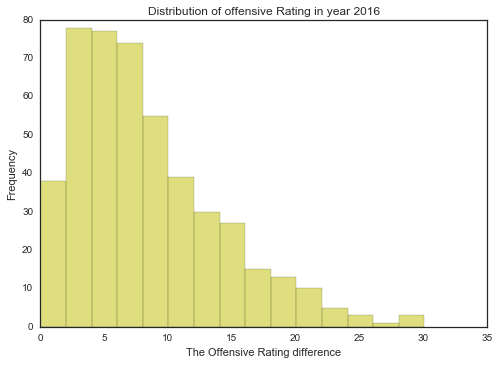

In [5]:
#plot a histogram
ortg_values = player_info['PTS'].values
plt.hist(ortg_values,color='y',bins=15,alpha =0.5)
plt.title("Distribution of offensive Rating in year 2016")
plt.xlabel('The Offensive Rating difference')
plt.ylabel('Frequency')


From the two plots above, we see that our two ratings could be treated as two normal distributions with two different shapes. Although for defensive ratings, it looks like a mixture Gaussian model, for the simplistic of this problem, we decided to treat them as normal distributions. 


Before we get to the further part, we need to figure out players in each team. We use binary indicators in this problem, which has the length of "player_num" vector will be generated, and if this player is playing, the number will be 1, 0 otherwise. 

In [7]:
# import the pickle files for guest/host teams line_up
with open('clean-data/guest_team_line_up.pkl', 'rb') as handle:
    guest_team_line_up = pickle.load(handle)
with open('clean-data/host_team_line_up.pkl','rb') as handle:
    host_team_line_up = pickle.load(handle)

We constructed two data indicators,which input the host/guest team **index** and return an binary indicator showing which team it is. For example, the first host team is "Atlanta Hawks", put 0 in host_team dictionary will return a 30-long array[True,Flase,...,False]. In this binary indicator, the team is ordered alphabetically. So, the first one is "Atlanta Hawks" and the second one "Boston Celtics". The "team_list" shows the order of the team. 

### A different approach to the likelihood function

In [8]:
def make_guest_host_mat(game_outcomes_df):
    '''
    Makes a matrix for guests and hosts. Each row of each
    matrix corresponds to one matchup. All elements of each row
    are zero except the ith one (different for each row).
    For the guest matrix, the ith entry in row j means that in game j,
    the guest team was team i. In the host matrix, the ith entry in
    row j means that the host team was team i
    '''
    
    def make_matrix(mat, indices):
        '''given a matrix and indices, sets the right one in each row
        to be true'''
        for (i, ind) in enumerate(indices):
            mat[i, ind] = True
        
    nrows = game_outcomes_df.shape[0]
    ncols = np.max(game_outcomes_df['Visitor_Index'] + 1)
    
    guest_matrix = np.zeros((nrows, ncols), dtype = bool)
    host_matrix = np.zeros((nrows, ncols), dtype = bool)
    
    make_matrix(guest_matrix, game_outcomes_df['Visitor_Index'].values)
    make_matrix(host_matrix, game_outcomes_df['Home_Index'].values)
    
    return(guest_matrix, host_matrix)

In [9]:
guest_matrix, host_matrix = make_guest_host_mat(game16_df)

In [39]:
2 *(team_num + player_num)

996

In [10]:
# Construct beta and gamma 
team_num = 30
player_num = len(player_info)

coefs = pm.MvNormalCov("coefs", mu = np.zeros(2*(team_num + player_num)),
                      C = np.eye(2*(team_num + player_num)))

# beta0 = np.empty(team_num,dtype=object)
# beta0 = pm.Container(np.array([pm.Normal('beta0_%i' % i, 
#                    mu=1, tau=1) for i in xrange(team_num)]))
# gamma0 = np.empty(team_num,dtype=object)
# gamma0 = pm.Container(np.array([pm.Normal('gamma0_%i' % i, 
#                    mu=1, tau=1) for i in xrange(team_num)]))
# betas = pm.Container(np.array([pm.Normal('betas_%i' % i, 
#                    mu=1, tau=1) for i in xrange(play_num)]))
# gammas = pm.Container(np.array([pm.Normal('gammas_%i' % i, 
#                    mu=1, tau=1) for i in xrange(play_num)]))
tau = pm.Gamma("tau", alpha = 2, beta = 2)

In [11]:
# Copy the variables from Andy's part
guest_lineup_arr = np.array(guest_team_line_up)
host_lineup_arr = np.array(host_team_line_up)
off_rating = player_info['PTS'].values + player_info['AST'].values
def_rating = player_info['BLK'].values + player_info["STL"].values + player_info['DRB'].values

In [12]:
def split_params(coefs, nplayers, nteams):
    '''
    Split the parameters
    first are the beta0 for each team
    then the beta for each player
    then the gamma0 for each team
    then the gamma for each player'''
    assert(coefs.shape == (2*(nplayers+nteams),))
    
    beta0 = coefs[:nteams]
    beta_player = coefs[nteams:(nplayers + nteams)]
    gamma0 = coefs[(nplayers + nteams):(nplayers + 2*nteams)]
    gamma_player = coefs[(nplayers + 2*nteams):]
    
    # parameterize sigma by its log
    #logsigma = coefs[-1]
    
    assert(beta0.shape == (nteams,))
    assert(beta_player.shape == (nplayers,))
    assert(beta0.shape == (nteams,))
    assert(gamma_player.shape == (nplayers,))
    
    
    return (beta0, beta_player, gamma0, gamma_player)#, logsigma)

In [14]:
# Use a different log-likelihood
from autograd.scipy.stats import norm
@pm.observed(name = "loglik", observed = True)
def loglik(coefs = coefs, tau = tau, value = score_diff, 
            off_rating = off_rating, def_rating = def_rating, 
            nplayers = player_num, nteams = team_num,
            guest_matrix = guest_matrix, host_matrix = host_matrix, guest_lineup_arr = guest_lineup_arr,
            host_lineup_arr = host_lineup_arr):

    beta0, betas, gamma0, gammas = \
             split_params(coefs, nplayers, nteams)
    
    ngames = value.shape[0]
    
    guest_off_0 = np.dot(guest_matrix, beta0)
    guest_def_0 = np.dot(guest_matrix, gamma0)
    host_off_0 = np.dot(host_matrix, beta0)
    host_def_0 = np.dot(host_matrix, gamma0)
    
    guest_off = guest_off_0 + np.dot(guest_lineup_arr, betas * off_rating)
    guest_def = guest_def_0 + np.dot(guest_lineup_arr, gammas * def_rating)
    host_off = host_off_0 + np.dot(host_lineup_arr, betas * off_rating)
    host_def = host_def_0 + np.dot(host_lineup_arr, gammas * def_rating)
    
    mean = guest_off - host_def - (host_off - guest_def)
    
    loglik = pm.normal_like(value, mean, tau)
#     loglik -= lam * np.linalg.norm(coefs[:-1])
    return(loglik)

In [16]:
parameterlist = [loglik, coefs, tau]
response_model2=pm.Model(parameterlist)

In [17]:
mcmc2 = pm.MCMC(response_model2)

In [30]:
mcmc2.sample(iter=50000, burn = 0, thin = 1)

 [-----------------100%-----------------] 50000 of 50000 complete in 1670.1 sec

In [31]:
coefs.trace()

array([[ 0.77432115,  2.46376387,  0.10093803, ..., -2.01115233,
        -4.11159667, -0.82238164],
       [ 0.77432115,  2.46376387,  0.10093803, ..., -2.01115233,
        -4.11159667, -0.82238164],
       [ 0.77432115,  2.46376387,  0.10093803, ..., -2.01115233,
        -4.11159667, -0.82238164],
       ..., 
       [-0.70943944,  0.87840375,  0.36462944, ..., -0.19914966,
        -1.96906939, -1.26325917],
       [-0.70943944,  0.87840375,  0.36462944, ..., -0.19914966,
        -1.96906939, -1.26325917],
       [-0.71974585,  0.88127392,  0.36668979, ..., -0.16649823,
        -1.97896747, -1.25400698]])

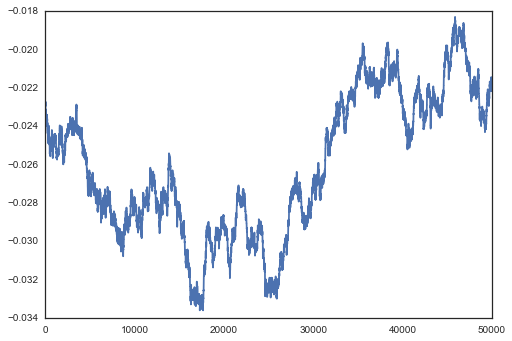

In [32]:
plt.plot(coefs.trace()[:, 70])

In [34]:
geweke_res = pm.geweke(coefs.trace()[:,70])

### Convergence Check
In order to check the model convergence, we picked "Golden State Warrior" as our example and check its convergence.

### Result Analysis

### Hypothesis 
In order to analyze the results, we use two metrics, the first one is to use the $\beta$ we got multiply offensive rating and multiply $\beta$ by Points Per Game. Also, we multiply $\gamma$ by players' defensive rating. To measure one team's performance, we could therefore to use $score = defensive + offensive$. Our hypothesis is that when two teams have similar scores genreated by our models, their games will be more fun and unpredicable. On the other hand, when two teams have a huge gap in this scores, their results shall be more predicable. 

We will check this hypothesis by predicting the score difference from different groups

In [15]:
# Read csv and analyze the data
mcmc.write_csv("pymcResult.csv")
pymc_result = pd.read_csv('pymcResult.csv')[['Parameter', ' Mean']]
beta_result = pymc_result[:451]
gamma_result = pymc_result[481:481+451]
rosters = player_info["Player"].values
player_PTS = player_info['PTS'].values
#Adjusted Contribution with Points per game
beta_result["Contribution* ortg"] = beta_result[' Mean'] * ortg_values
beta_result["Contribution* PTS(P. P. Game)"] = beta_result[' Mean'] * player_PTS
beta_result.head()

/Users/xdai/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/xdai/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Parameter,Mean,Contribution* ortg,Contribution* PTS(P. P. Game)
0,beta_0,-0.821082,-78.002770,-25.699860
1,beta_1,0.012389,1.288434,0.230432
2,beta_2,0.160221,18.585585,5.848050
3,beta_3,-1.228993,-131.502271,-39.327782
4,beta_4,0.954801,105.982924,20.050823


In [16]:
#Process gamma result 
gamma_result["Contribution* drtg"] = gamma_result[' Mean'] * drtg_values
gamma_result.head()

/Users/xdai/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,Parameter,Mean,Contribution* drtg
481,gamma_0,-1.208653,-136.577741
482,gamma_1,-1.360216,-153.704450
483,gamma_2,0.417258,42.977621
484,gamma_3,-0.120567,-12.900645
485,gamma_4,-0.207312,-21.560437


### Make predictions

In [103]:
la_clippers_beta = beta_result[host_team_line_up[18]]
la_clippers_beta['Player'] = rosters[la_clippers_beta.index]
la_clippers_beta.head()
la_clippers_gamma = gamma_result[host_team_line_up[18]]
la_clippers_gamma['Player'] = rosters[la_clippers_beta.index]
la_clippers_offensive  = np.sum(la_clippers_beta["Contribution* PTS(P. P. Game)"].values)
la_clippers_defensive = np.sum(la_clippers_gamma["Contribution* drtg"].values)
score = la_clippers_offensive + la_clippers_defensive
print "The score of la_clippers is:", score

The score of la_clippers is: -79.9154831064


/Users/xdai/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/xdai/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [ ]:
la_clippers_beta = beta_result[host_team_line_up[18]]
la_clippers_beta['Player'] = rosters[la_clippers_beta.index]
la_clippers_beta.head()
la_clippers_gamma = gamma_result[host_team_line_up[18]]
la_clippers_gamma['Player'] = rosters[la_clippers_beta.index]
la_clippers_offensive  = np.sum(la_clippers_beta["Contribution* PTS(P. P. Game)"].values)
la_clippers_defensive = np.sum(la_clippers_gamma["Contribution* drtg"].values)
score = la_clippers_offensive + la_clippers_defensive
print "The score of la_clippers is:", score

In [105]:
#Find the Golden State Warrior Member
gs_warriors = beta_result[host_team_line_up[2]]
gs_warriors['Player'] = rosters[gs_warriors.index]
gs_warriors

/Users/xdai/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,Parameter,Mean,Contribution* ortg,Contribution* PTS(P. P. Game),Player
28,beta_28,0.492629,55.174450,15.813392,Klay Thompson
37,beta_37,-0.938370,-107.912577,-18.298220,Draymond Green
58,beta_58,2.459972,295.196676,30.749654,Andrew Bogut
63,beta_63,1.962966,225.741116,24.929671,Andre Iguodala
64,beta_64,-0.313012,-39.126544,-13.303025,Stephen Curry
118,beta_118,0.467475,55.629584,7.339365,Jason Thompson
134,beta_134,-0.322025,-38.321004,-4.991391,Shaun Livingston
186,beta_186,-0.015555,-1.773266,-0.284656,Harrison Barnes
187,beta_187,0.017752,1.810710,0.527236,Marreese Speights
247,beta_247,0.091441,9.692720,1.773951,Leandro Barbosa


In [59]:
np.sum(gs_warriors["Contribution*PTS(ortg)"].values)

169.82556171737411

In [17]:
# check Curry's score
beta_result[beta_result['Parameter'] == 'beta_64']

,Parameter,Mean,Contribution* ortg,Contribution* PTS(P. P. Game)
64,beta_64,2.262351,282.793916,96.149931


In [21]:
beta_result['Player'] = rosters

/Users/xdai/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [26]:
beta_result.keys()

Index([u'Parameter', u' Mean', u'Contribution* ortg',
       u'Contribution* PTS(P. P. Game)', u'Player'],
      dtype='object')

In [28]:
beta_result.sort_values(['Contribution* PTS(P. P. Game)'],ascending=False)

,Parameter,Mean,Contribution* ortg,Contribution* PTS(P. P. Game),Player
266,beta_266,8.073223,888.054548,193.757356,Kelly Olynyk
373,beta_373,5.330408,1087.403195,176.436499,Rakeem Christmas
362,beta_362,8.242820,931.438677,168.977813,Cole Aldrich
19,beta_19,5.138913,621.808450,168.556340,Kawhi Leonard
9,beta_9,4.470250,460.435797,143.048015,Dwyane Wade
70,beta_70,11.218449,1189.155646,126.768479,Omer Asik
357,beta_357,5.528534,691.066705,114.440646,Kevon Looney
274,beta_274,3.982852,438.113677,103.155857,Shabazz Muhammad
423,beta_423,4.711010,461.678996,98.460112,Jarell Eddie
220,beta_220,4.660036,489.303788,97.860758,Luis Scola
